In [ ]:
import random
from tqdm import tqdm#진행률 바 형태로 출력

import torch
import torch.nn as nn
from torch.nn import functional as F#신경망 관련 함수 불러오는거
from torch.utils.data.sampler import SubsetRandomSampler#데이터셋에서 일부 샘플만 무작위로 추출해 사용할수 있게 해주는 샘플러

from torchsummary import summary#torch 모델의 구조와 파라미터 수 출력 도구

import torchvision.transforms as T#이미지 전처리
from torchvision.datasets import MNIST

from sklearn.manifold import TSNE#고차원 데이터를 2차원 또는 3차원으로 시각화

import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
def make_fig(z, targets, epoch): #고차원 z를 2차원 데이터로 축소하고 클래스별로 색을 다르게 표시한 시각화 이미지 저장

    model = TSNE()#t-SNE 생성/ 차원 축소 기법. 데이터간의 유사성을 보존하면서 , 시각적으로 클러스터가 잘 보이도록 도와줌.
    transformed = model.fit_transform(z)#z를 t-SNE를 이용하여 2차원 데이터로 축소.

    plt.scatter(transformed[:, 0], transformed[:, 1], c=targets, alpha=.4, s=3**2)
    #transformed[:.0] -> 0번쨰 데이터만 들고오는것.
    #plt.scatter(x,y,점 색깔을 레이블에 따라 다르게, 점의 크기)
    #2차원 좌표로 산점도 그림

    plt.savefig(fname=f'{epoch}.png', format='png')#시각화 결과를 PNG 이미지 파일로 저장

### 학습된 모델이 데이터를 어떻게 구분했는지 확인할 때 유용

In [ ]:
LR = 0.0001
EPOCH = 600
BATCH_SIZE = 256

LATENT_DIM = 3

In [ ]:
class SubsetSequentialSampler(torch.utils.data.Sampler):# 데이터셋에서 어떤 인덱스를 어떤 순서로 뽑을지 정의하는 클래스
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))# 인덱스를 하나씩 꺼낼수 있음

    def __len__(self):
        return len(self.indices)#샘플 개수

train = MNIST('./', train=True, download=True, transform=T.ToTensor())#To.Tensor PIL또는 Numpy 이미지 torch.tensor로 변환/ pytorch는 tensor형태만 입력으로 받는다.
test = MNIST('./', train=False, download=True, transform=T.ToTensor())

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)#데이터 꺼내서 모델에 입력으로 넣기 좋은 형태로 만들기.
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.01MB/s]


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__() #부모 클래스 초기화

        self.fc_1 = nn.Linear(28*28, 256)# 입력 이미를 펼쳐서 256차원으로 줄임.완전연결층
        self.fc_2 = nn.Linear(256, 128)#256에서 128로 줄이는 완전연결층
        self.fc_3 = nn.Linear(128, 32)#128에서 32로 줄이는 완전 연결층

        #LATENT_DIM : 잠재 공간의 차원수. 위에서 3이라고 정의함.
        self.fc_mu = nn.Linear(32, LATENT_DIM) #평균은 3차원
        self.fc_var = nn.Linear(32, LATENT_DIM) #분산은 3차원

        self.leaky = nn.LeakyReLU(inplace=False)# 인코더는 입력 데이터를 잠재 벡터로 압축. 비선형이 필요해서 leakyrelu 사용,
        # relu는 음수를 다 0으로 만들기 때문에, 뉴런이 완전히 죽을수 있다. 그래서 음수일때도 작은 기울기로 정보가 조금씩 흐를수있게 , 안정적으로 학습하게
        # 사용하는것......
        # inplace=False 이건 원본을 유지하고 새로 계산된 값 반환. True면 기존값 덮어씀.
        # True하면 원본값 날라가서 역전파에서 그 값을 기반으로 오차의 gradient 계산 못하니깐.

    def forward(self, x):#순전파 함수 정의
        x = x.flatten(1) #이미지 텐서 펼치기. 왜냐면 nn.linear가 1차원 벡터만 받아서. 와우...
        out = self.leaky(self.fc_1(x))#첫 번째 완전연결층 + LeakyReLU
        #fc_1(x)하면 1차원 벡터가 완전 연결층(입력과 출력 뉴런이 모두 연결된 구조)으로 특징 추출(압축)하고 근데 이건 선형이야
        #leaky로 비선형성을 부가해 그러면 더 복잡한 패턴을 학습할 수 있지.
        out = self.leaky(self.fc_2(out))
        out = self.leaky(self.fc_3(out)) #32차원으로 줄임.

        out = out.view(out.size(0), -1)# 계산하다가 불필요한 값이 끼면 문제가 되니깐 납작하게 정리해주는것.
        # out = (out.size, 나머지 자동 평탄화) -> [64,32] 이런식으로 바꿔주는거임
        # 바꾸는 이유는 ... nn.Linear가 이런 형태만 받을수 있기 때문임.(batch, feature)

        mu = self.fc_mu(out) # linear로 연산이 가능해진 out은 fc_mu를 통해 32차원에서 3차원으로 선형 변환됨. 결과는 [batch,3]
        log_var = self.fc_var(out)

        return [mu, log_var]

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.fc = nn.Linear(LATENT_DIM, 32)#encoder 3차원으로 줄엿으니 이제 다시 원상복귀 해주는거임.

        self.fc_1 = nn.Linear(32, 128)
        self.fc_2 = nn.Linear(128, 256)
        self.fc_3 = nn.Linear(256, 28*28) # 784로 복원 완료

        self.leaky = nn.LeakyReLU(inplace=False) # encoder에서도 비선형으로 줄였때문에 선형만으론 그것을 다시 못푼다. 그래서 추가한거임.
        # encoder -> 비선형을 이용해서 특징 추출
        # decoder -> 비선형을 이용해 관계 해석하여 복원
        # 즉 인코더ㅔ서 추출한 비선형적인 특징을 복원하기 위해선 디코더에서도 비선형을 이용해 특징을 원복한다. (선형으론 비선형 복구 불가)
        self.sigmoid = nn.Sigmoid()
        # 값을 정규화하여 [0,1]형태로 바꿔준다. sigmoid는 0~1의 값으로만 나타내게 해주는거임
        # 이미지 픽셀 범위와 맞춰주기위해서 꼭 사용해야함.

    def forward(self, x):
        out = self.leaky(self.fc(x))

        out = self.leaky(self.fc_1(out))
        out = self.leaky(self.fc_2(out))
        out = self.fc_3(out) # 비선형을 넣으면 사이즈 즉 결과값에 왜곡이 들어갈수 있음.

        out = out.view(out.size(0), 1, 28, 28)

        return self.sigmoid(out)

In [ ]:
class Model(nn.Module): # 전체 VAE 모델을 정의하는 클래스
    def __init__(self):
        super(Model, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x): #
        mu, log_var = self.encoder(x) # 인코더에서 구한 평균과 분산

        z = self.reparameterize(mu, log_var)#잠재변수->압축해서 뽑아낸 핵심 특징 표현

        recon = self.decoder(z) #복원된 이미지

        return recon, mu, log_var

    def loss_function(self, target, recon, mu, log_var):
        recon_loss = F.binary_cross_entropy(recon, target, reduction='sum')
        # 입력이미지와 복원이미지 사이의 차이
        kld_loss = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - log_var - 1)
        #
        loss = recon_loss + kld_loss
        # 원복을 복원하면서 생기는 손실값.

        return loss

    def reparameterize(self, mu, log_var): # z 즉 특징 추출
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def generate(self, **kwargs):
        x = torch.rand(1, LATENT_DIM).cuda()
        return self.decoder(x)[0]

    def get_z(self, x):
        mu, log_var = self.encoder(x)

        return self.reparameterize(mu, log_var)

In [ ]:
model = Model().cuda()#VAE 모델 생성

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
# 파라미터 최적화할 옵티마이저 설정.
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 100, 200, 300, 400])
#학습률 조정해주는거. epoch마다 학습률ㅈ ㅏ동으로 낮춰주는거임. 나중엔 더 정교하게 학습하려고
summary(model, input_size=(1, 28, 28))
#

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
         LeakyReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
         LeakyReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 32]           4,128
         LeakyReLU-6                   [-1, 32]               0
            Linear-7                    [-1, 3]              99
            Linear-8                    [-1, 3]              99
           Encoder-9         [[-1, 3], [-1, 3]]               0
           Linear-10                   [-1, 32]             128
        LeakyReLU-11                   [-1, 32]               0
           Linear-12                  [-1, 128]           4,224
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                  [

In [9]:
for epoch in range(EPOCH): #VAE 모델의 학습 루프.
    model.train()#모델을 학습 모드로 설정함.
    for img, target in tqdm(train_loader, leave=False, total=len(train_loader)):
        # len(train_loder) = 전체 데이터개수 // batch_size
        img = img.cuda()
        target = target.cuda()

        recon, mu, log_var = model(img) # 이미지 넣고 평균,분산로그, 복원이미지

        optimizer.zero_grad() #기울기 초기화. loss.backword로 계산된 기울기가 정확하게 반영.

        loss = model.loss_function(img, recon, mu, log_var) #원본을 복원본으로 변환하면서 생긴  loss값

        loss.backward() #역전파
        optimizer.step() #파라미터 없데이트

    scheduler.step()
    if not epoch % 50:
        print(loss)

tensor(19988.3359, device='cuda:0', grad_fn=<AddBackward0>)


tensor(14898.2529, device='cuda:0', grad_fn=<AddBackward0>)


tensor(14116.8096, device='cuda:0', grad_fn=<AddBackward0>)


tensor(13835.4316, device='cuda:0', grad_fn=<AddBackward0>)


tensor(14734.0049, device='cuda:0', grad_fn=<AddBackward0>)


tensor(13730.9043, device='cuda:0', grad_fn=<AddBackward0>)


tensor(13411.6025, device='cuda:0', grad_fn=<AddBackward0>)


tensor(13628.7441, device='cuda:0', grad_fn=<AddBackward0>)


tensor(14299.1416, device='cuda:0', grad_fn=<AddBackward0>)


tensor(14220.2803, device='cuda:0', grad_fn=<AddBackward0>)


tensor(13758.8857, device='cuda:0', grad_fn=<AddBackward0>)


tensor(13249.0479, device='cuda:0', grad_fn=<AddBackward0>)


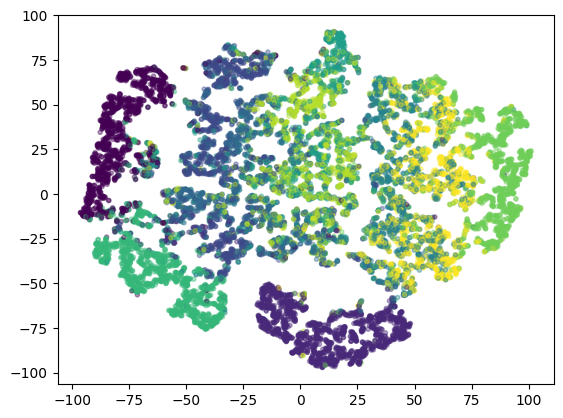

In [10]:
model.eval()
# 모델 평가모드로 전환. dropout, batchnorm 비활성화
with torch.no_grad():
    features = torch.tensor([]).cuda()
    # 잠재 벡터 z를 저장할 빈 텐서
    targets = torch.tensor([]).cuda()
    #이미지의 라벨을 저장할 빈 텐서

    for (img, target) in train_loader:# 이미지와 라벨
        img = img.cuda()#이미지를 gpu 가 연산 가능하게 만든다.
        target = target.cuda()#라벨이 gpu가 연산 가능하게 만든다.

        z = model.get_z(img)# 특징추출

        features = torch.cat((features, z), 0)# 모든 z값을 다 이어 붙이기.
        targets = torch.cat((targets, target), 0)#z값에 해당하는 라벨 다 이어 붙이기.

features = features.cpu().numpy()# Z 모든값을 numpy로 바꿈
targets = targets.cpu().numpy()# z 모든값에 해당하는 라벨을 numpy로 바꿈
make_fig(features[:15000], targets[:15000], 'train')

In [ ]:
with torch.no_grad():
    features = torch.tensor([]).cuda()
    targets = torch.tensor([]).cuda()
    for (img, target) in test_loader:
        img = img.cuda()
        target = target.cuda()

        z = model.get_z(img)

        features = torch.cat((features, z), 0)
        targets = torch.cat((targets, target), 0)

features = features.cpu().numpy()
targets = targets.cpu().numpy()
make_fig(features[:], targets[:], 'test')

In [12]:
T.functional.to_pil_image(model.generate())